## Unrate

In [2]:
import keras 
import json
import pandas as pd 
import requests
import statsmodels.api as sm
import seaborn as sea
import matplotlib.pyplot as plt

Os dados serão pegues diretamente do fred, e nele contem a taxa mensal de desemprego os estados unidos

In [3]:
# Importando key para api do Fred
with open('api-key.json') as f:
    key = json.load(f)
key = key['key']

In [4]:
URL = f'https://api.stlouisfed.org/fred/series/observations?series_id=UNRATE&api_key={key}&file_type=json'

response = requests.get(URL)
data = response.json()
data = pd.DataFrame(data['observations'])

In [5]:
# Removendo colunas desnecessarias
data = data[['date', 'value']]

# Convertendo para FLOAT
data['value'] = data['value'].astype(float)

# Convertendo para datetime
data['date'] = pd.to_datetime(data['date'])

# Setando como index
data.set_index('date', inplace=True)

In [6]:
data.rename(columns={'value': 'unrate'}, inplace=True)

In [7]:
data.head()

,unrate
date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


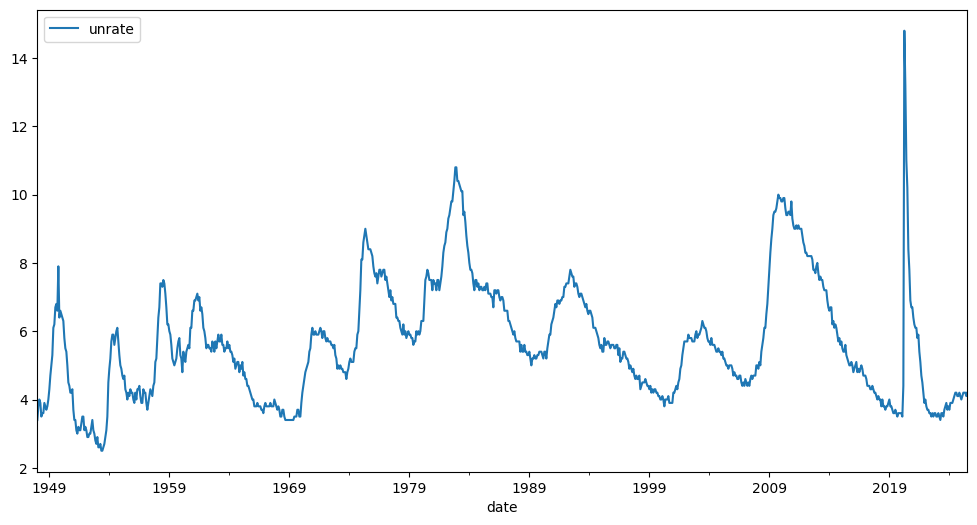

In [163]:
data.plot(figsize=(12,6))
plt.show()

In [164]:
data.index.year.unique().shape

(78,)

> Há 78 anos

Verificando a média movel e variancia movel com uma janela dos ultimos 3 anos

In [165]:
media_movel = data['unrate'].rolling(window=12*3).mean()
variancia_movel = data['unrate'].rolling(window=12*3).var()

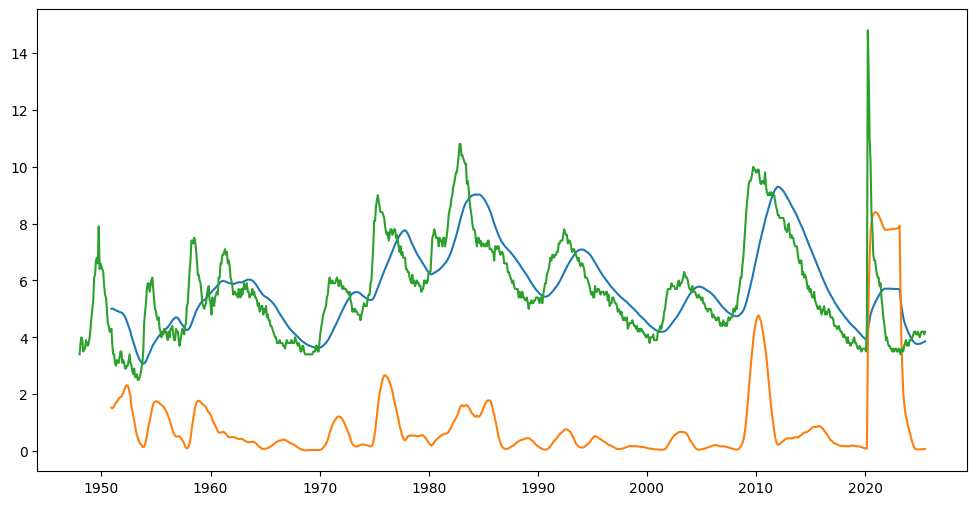

In [166]:
plt.figure(figsize=(12,6))
plt.plot(media_movel)
plt.plot(variancia_movel)
plt.plot(data['unrate'])
plt.show()

> Em primeira instancia vemos que o processo não é estacionario

Mes com maior freguencia com alta taxa de desemprego

In [167]:
data['ano'] = data.index.year
data['mes'] = data.index.month
data_max = data.loc[data.groupby('ano')['unrate'].idxmax()]
data_max = data_max.loc[data_max.groupby('ano')['mes'].idxmax()]

In [168]:
data_max['mes'] = data_max.index.month_name(locale='pt_BR')

In [169]:
subset = data_max.groupby('mes')['ano'].apply(lambda x: ', '.join([ str(i) for i in x.unique().tolist()]))

In [170]:
subset.reset_index()

,mes,ano
0,Abril,"1995, 2016, 2020"
1,Agosto,"1952, 1971, 1979"
2,Dezembro,"1953, 1957, 1960, 1970, 1974, 1981, 1990, 1991..."
3,Fevereiro,"1963, 1965, 1968, 1973, 1977, 1986, 1999, 2000..."
4,Janeiro,"1950, 1951, 1955, 1959, 1962, 1964, 1966, 1972..."
5,Julho,"1956, 1958, 1980, 2024"
6,Junho,"1985, 1992, 2003"
7,Maio,"1961, 1975"
8,Março,"1948, 1998, 2004, 2010, 2025"
9,Novembro,1982


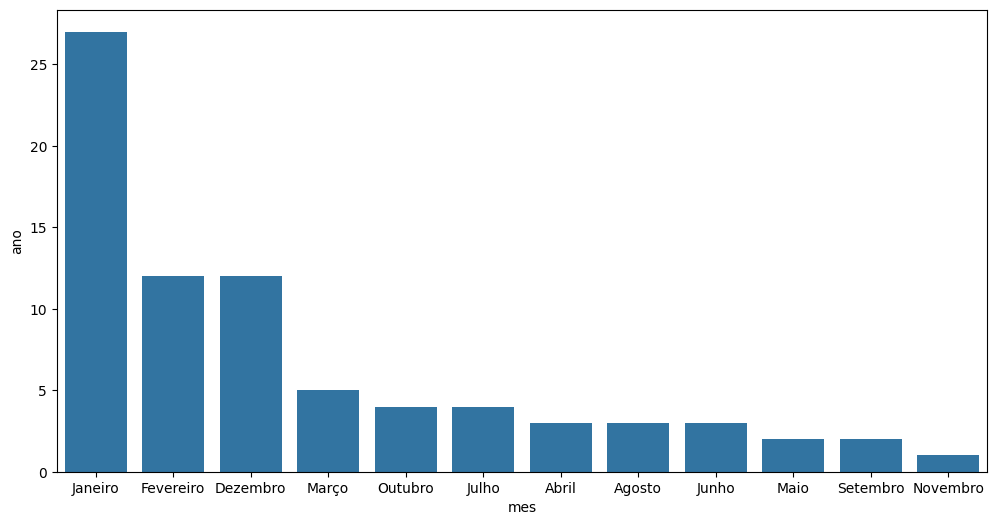

In [171]:
subset = data_max.groupby('mes')['ano'].count().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sea.barplot(subset)
plt.show()

> Mes de janeiro seguido por Feveiro e Dezembro são que mais possuem ocorrencia de alta taxa de desemprego

### Criando modelo

In [172]:
dataset = data['unrate']

In [173]:
train_size = int(len(data) * 0.8)

> São pouca instancias para treinar uma modelo de rede neural. Contudo para fins de aprendizado será feito assim!

1. Vou escalonar os dados evitando o lockhead

In [176]:
# Escalonando seguindo uma media movel
train_ewan_mean = dataset.ewm(span=12*3).mean()
train_ewan_std  = dataset.ewm(span=12*3).std()

In [177]:
dataset_std = (dataset - train_ewan_mean ) / train_ewan_std
dataset_std = dataset_std.dropna()

<Axes: xlabel='date'>

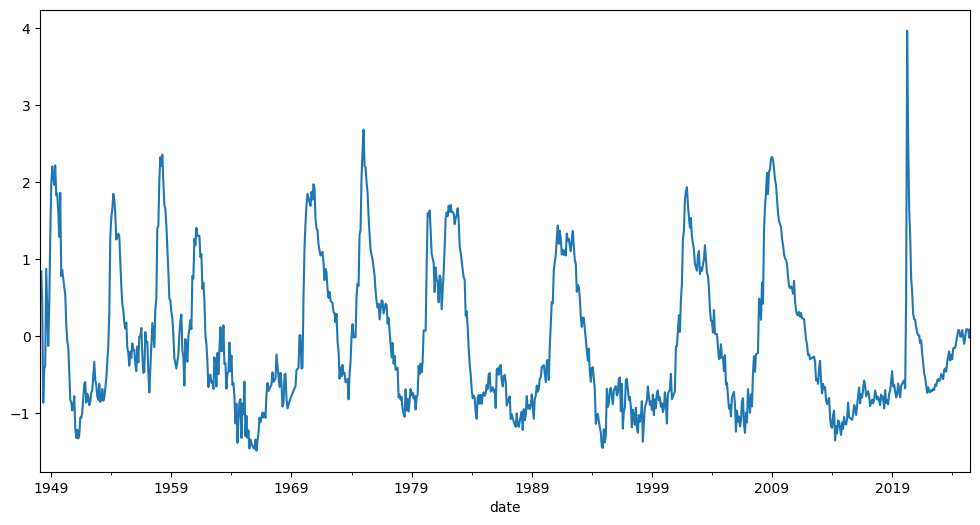

In [179]:
dataset_std.plot(figsize=(12,6))

Dividindo dados de treino e teste

In [ ]:
train_std, test_std = dataset_std[:train_size], dataset_std[train_size:]

In [181]:
import numpy as np
def prepare_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [182]:
xtrain, ytrain = prepare_dataset(train_std, 12)
xtest, ytest = prepare_dataset(test_std, 12)

C:\Users\mateu\AppData\Local\Temp\ipykernel_8744\2316501450.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataY.append(dataset[i + look_back])


In [217]:
model = keras.models.Sequential([
    keras.layers.InputLayer(shape=(12,1)),
    keras.layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Bidirectional(keras.layers.LSTM(50)),
    keras.layers.Dense(1)
])

In [218]:
model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mean_absolute_error']
)

In [219]:
model.fit(
    xtrain, ytrain, 
    epochs=50, 
    shuffle=False, 
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    ],
    verbose=0
)

In [220]:
pred = model.predict(xtest)

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 667ms/step


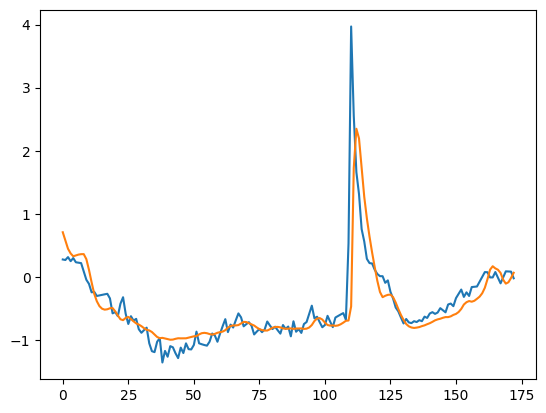

In [221]:
plt.plot(ytest)
plt.plot(pred)
plt.show()

In [222]:
ultimo = xtrain[-1].reshape(1,12)

lista = []
for i in range(len(ytest)):
    pred_i = model.predict(ultimo, verbose=0)
    
    ultimo = np.append(ultimo[0][1:], pred_i)
    ultimo = ultimo.reshape(1,12)
    
    lista.append(pred_i.tolist()[0][0])

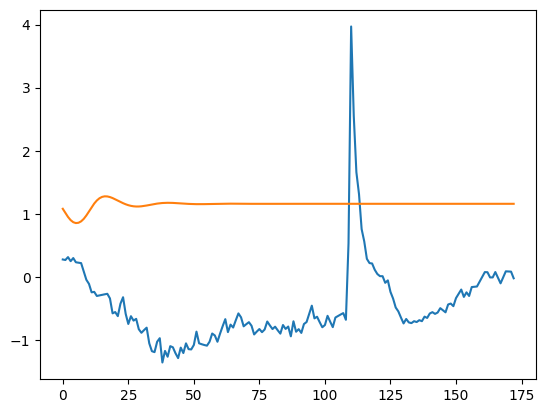

In [223]:
plt.plot(ytest)
plt.plot(lista)
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


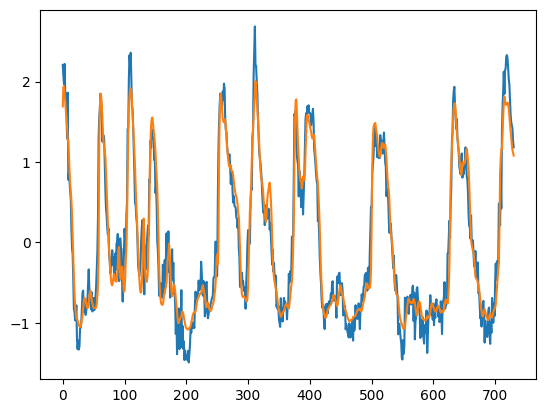

In [225]:
plt.plot(ytrain)
plt.plot(model.predict(xtrain))
plt.show()

Usando diff

In [233]:
subset = dataset_std.diff().dropna()

train_diff, test_diff = subset[:train_size], subset[train_size:]

xtrain, ytrain = prepare_dataset(train_diff, 12)
xtest, ytest = prepare_dataset(test_diff, 12)

C:\Users\mateu\AppData\Local\Temp\ipykernel_8744\2316501450.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataY.append(dataset[i + look_back])


In [236]:
ytrain = ytrain.reshape(-1,1)
ytest = ytest.reshape(-1,1)

In [238]:
model = keras.models.Sequential([
    keras.layers.InputLayer(shape=(12,1)),
    keras.layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)
])

In [239]:
model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mean_absolute_error']
)

In [244]:
import tensorboard

In [240]:
model.fit(
    xtrain, ytrain, 
    epochs=50, 
    shuffle=False, 
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    ],
    verbose=0
)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step


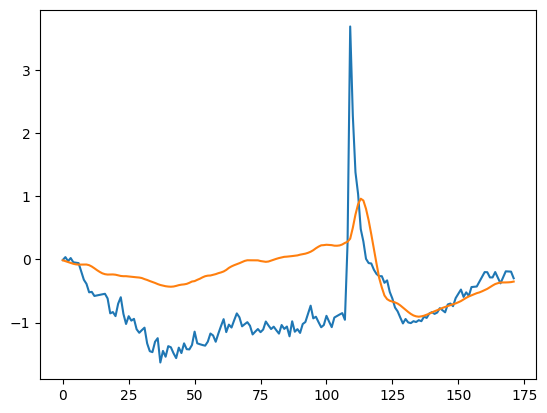

In [241]:
plt.plot(ytest.cumsum())
plt.plot(model.predict(xtest).cumsum())
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


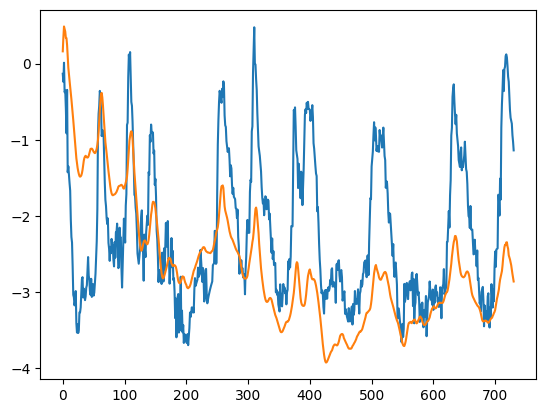

In [242]:
plt.plot(ytrain.cumsum())
plt.plot(model.predict(xtrain).cumsum())
plt.show()

Usando prophet

In [1]:
import prophet

c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
data_prop = data.reset_index().rename(columns={'date': 'ds', 'unrate': 'y'})

In [13]:
model = prophet.Prophet()

model.fit(data_prop)

11:40:10 - cmdstanpy - INFO - Chain [1] start processing
11:40:11 - cmdstanpy - INFO - Chain [1] done processing


c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning\venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


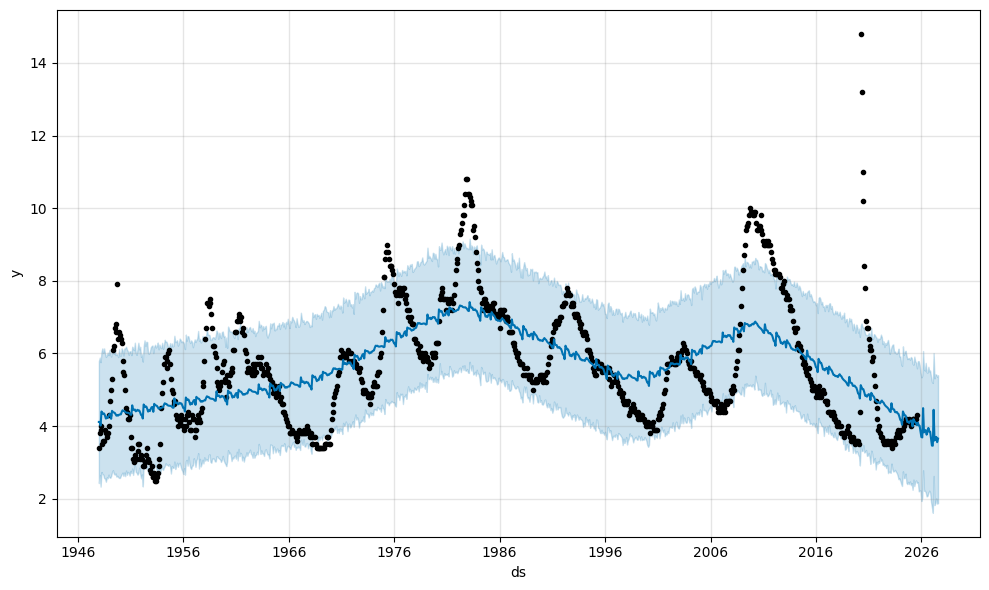

In [16]:
future = model.make_future_dataframe(periods=24, freq='M')
forecast = model.predict(future)

fig = model.plot(forecast)